In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import uproot
import torch
import numpy as np
from matplotlib.ticker import FuncFormatter

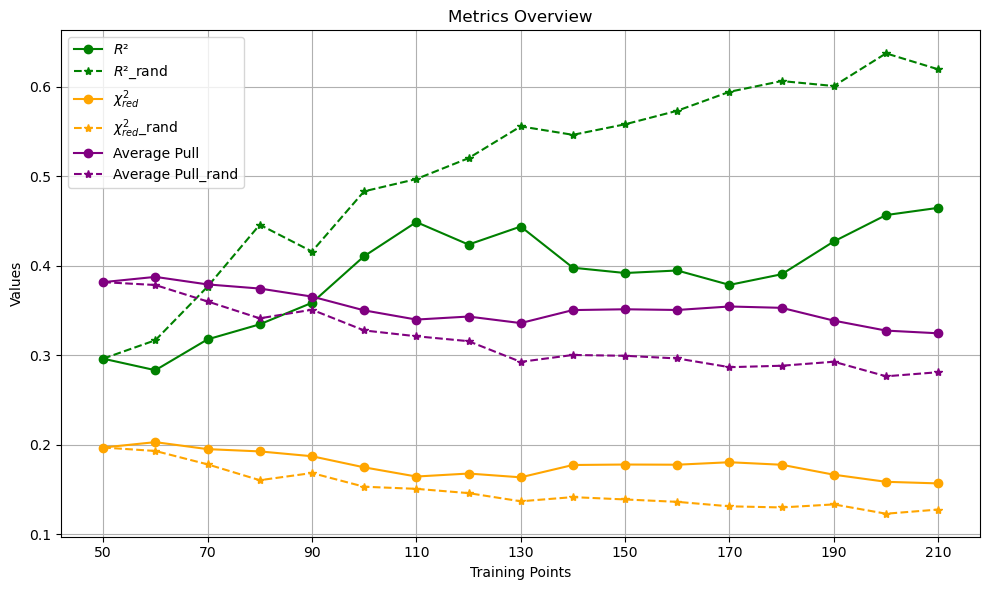

In [10]:
df = pd.read_csv('gof.csv')
df_rand = pd.read_csv('gof_rand.csv')
df_rand = df_rand[:17]

# Erstellen eines einzigen Plots mit allen Metriken und einer Legende
plt.figure(figsize=(10, 6))

# Plot für mean_squared_0 und mean_squared_1
#plt.plot(df.index, df['mean_squared_0'], label='mean_squared_0', marker='o')
# plt.plot(df.index, df['mean_squared_1'], label='mean_squared_1', marker='o')

# Plot für r_squared
plt.plot(df.index, df['r_squared'], label='$R²$', marker='o', color='green')
plt.plot(df_rand.index, df_rand['r_squared'], label='$R²$_rand', marker='*', color='green', linestyle='--')

# Plot für chi_squared_0 und chi_squared_1
#plt.plot(df.index, df['chi_squared_0'], label='chi_squared_0', marker='o', color='red')
plt.plot(df.index, df['chi_squared_1'], label='$\chi_{red}^2$', marker='o', color='orange')
plt.plot(df_rand.index, df_rand['chi_squared_1'], label='$\chi_{red}^2$_rand', marker='*', color='orange', linestyle='--')


# Plot für average_pull_0 und average_pull_1
plt.plot(df.index, df['average_pull_0'], label='Average Pull', marker='o', color='purple')
plt.plot(df_rand.index, df_rand['average_pull_0'], label='Average Pull_rand', marker='*', color='purple', linestyle='--')
#plt.plot(df.index, df['average_pull_1'], label='average_pull_1', marker='o', color='brown')

# Titel und Legende hinzufügen
plt.title('Metrics Overview')
plt.xlabel('Training Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# X-Achse um den Faktor 10 skalieren
def x_tick_formatter(x, pos):
    return f'{x * 10 + 50:.0f}'  # Multipliziert die x-Werte mit 10 und entfernt Dezimalstellen

plt.gca().xaxis.set_major_formatter(FuncFormatter(x_tick_formatter))

# Plot anzeigen
plt.tight_layout()
plt.show()

In [10]:
path = '/u/dvoss/al_pmssmwithgp/Run3ModelGen/source/Run3ModelGen/scans/scan_true/ntuple.0.0.root'

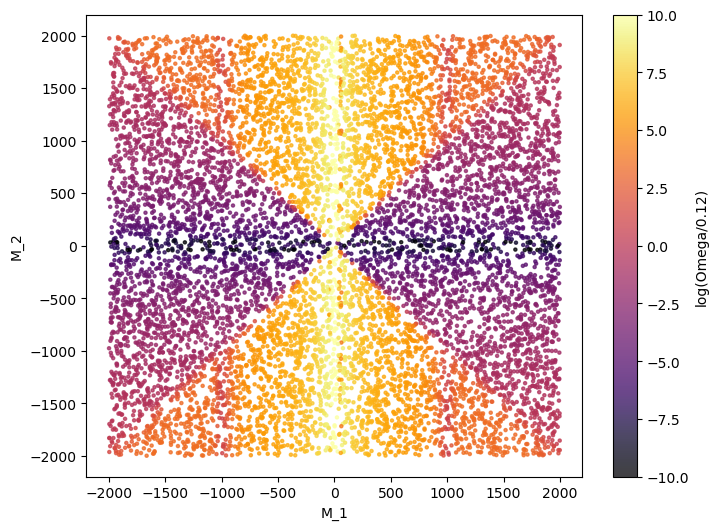

In [48]:
def plotTrue(path):
        '''Plot the 2D GP with a Heatmap and the new points and save it in the plot folder'''

        # Open the ROOT file
        file = uproot.open(path)
        
        tree_name = "susy"
        tree = file[tree_name]
        
        # Convert tree to pandas DataFrame
        df = tree.arrays(library="pd")

        M_1 = df['IN_M_1'].values
        M_2 = df['IN_M_2'].values
        Omega = df['MO_Omega'].values

        # Create a mask to filter out negative or zero values of Omega
        mask = Omega > 0

        # Apply the mask to filter M_1, M_2, and Omega
        M_1_filtered = M_1[mask]
        M_2_filtered = M_2[mask]
        Omega_filtered = Omega[mask]

        # Calculate the true values (log-scaled)
        true = torch.log(torch.tensor(Omega_filtered, dtype=torch.float32) / 0.12)
        
        # heatmap, xedges, yedges = np.histogram2d(M_1_filtered, M_2_filtered, bins=50, weights=true.cpu().numpy())
        # heatmap_counts, xedges, yedges = np.histogram2d(M_1_filtered, M_2_filtered, bins=50)
        # heatmap = heatmap/heatmap_counts

        plt.figure(figsize=(8, 6))
        #plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
        plt.scatter(M_1_filtered, M_2_filtered, vmin=-10, vmax=10, c=true.cpu().numpy(), cmap='inferno', s=5, alpha=0.75)
        plt.colorbar(label='log(Omega/0.12)')
        plt.xlabel('M_1')
        plt.ylabel('M_2')

        plt.show()


plotTrue(path)


(10000,) (10000,) (10000,)


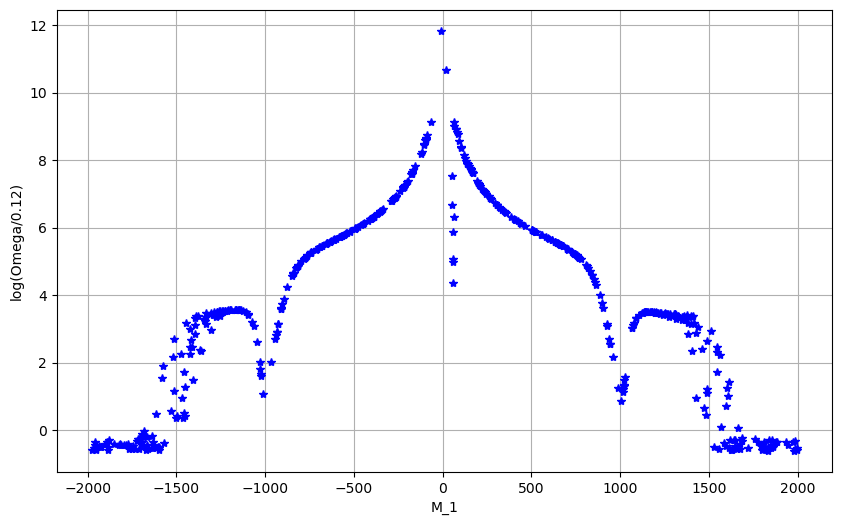

In [61]:
def plotSlice1D(slice_dim=0, slice_value=1000, tolerance=0.01, path = None):

        # Start plotting
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        
        ax1.set_xlabel(f'M_{"2" if slice_dim == 0 else "1"}')
        ax1.set_ylabel('log(Omega/0.12)')
        ax1.grid(True)

        # Plot true data points
        if path:
            # Open the ROOT file
            file = uproot.open(path)
            tree_name = "susy"
            tree = file[tree_name]
            
            # Convert tree to pandas DataFrame
            df = tree.arrays(library="pd")
            M_1_filtered = df['IN_M_1']
            M_2_filtered = df['IN_M_2']
            Omega = df['MO_Omega']
            mask = Omega > 0
            Omega_filtered = Omega#[mask]

            print(M_1_filtered.shape, M_2_filtered.shape, Omega_filtered.shape)

            # Normalize the true data
            if slice_dim == 0:
                indices_true = np.where((M_1_filtered >= slice_value - tolerance) & (M_1_filtered <= slice_value + tolerance))[0] # Creates tuple from which we take the first index
                x_true = M_2_filtered[indices_true] # Is marginalized along M_1, so M_2 is x_coordinate
            else:
                indices_true = np.where((M_2_filtered >= slice_value - tolerance) & (M_2_filtered <= slice_value + tolerance))[0]
                x_true = M_1_filtered[indices_true] # Is marginalized along M_2, so M_1 is x_coordinate
            y_true = torch.log(torch.tensor(Omega_filtered.values, dtype=torch.float32) / 0.12).cpu().numpy()
            y_true = y_true[indices_true]
            ax1.plot(x_true, y_true, '*', c='b', label = 'True Function')

            plt.show()

plotSlice1D(slice_dim=1, slice_value=1500, tolerance=100, path=path)